In [345]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import PchipInterpolator

In [346]:
batch_size = 1024
val_loss_steps_file = f"val_loss_steps_bs_{batch_size}_1.3B.csv"
val_loss_time_file = f"val_loss_time_bs_{batch_size}_1.3B.csv"

# Plot loss vs steps

In [347]:
# Load CSV exported from wandb
data = pd.read_csv(val_loss_steps_file)

# remove columns with name ending in __MIN or __MAX
selected_cols = [
    col
    for col in data.columns
    if not col.endswith("__MIN") and not col.endswith("__MAX")
]
data = data.loc[:, selected_cols]

print(f"Data columns: {data.columns}")

Data columns: Index(['Step', '(dion)_bs=1024_lr=0.01_sp=1.0_1.3B - val/loss',
       '(dion)_bs=1024_lr=0.01_sp=0.25_1.3B - val/loss',
       '(dion)_bs=1024_lr=0.01_sp=0.0625_1.3B - val/loss',
       '(muon_moonlight)_bs=1024_lr=0.01_sp=1.0_1.3B - val/loss',
       '(adam)_bs=1024_lr=0.002_sp=1.0_1.3B - val/loss'],
      dtype='object')


In [348]:
def get_column_by_name(data, name, sparsity=None):
    col_name = [col for col in data.columns if name in col.lower()]
    if sparsity is not None:
        col_name = [col for col in col_name if f"sp={sparsity}" in col]
    assert len(col_name) == 1, col_name
    return col_name[0]


def create_interp(data, name, sparsity=None):
    col_name = get_column_by_name(data, name, sparsity)
    step_col_name = get_column_by_name(data, "step")
    col_data = data[col_name]
    step_data = data[step_col_name]
    idx = np.argsort(col_data)
    interp = PchipInterpolator(col_data[idx], step_data[idx])
    return interp


adam_interp = create_interp(data, "adam")
muon_interp = create_interp(data, "muon")
dion_1_interp = create_interp(data, "dion", sparsity=1.0)
dion_4_interp = create_interp(data, "dion", sparsity=0.25)
dion_16_interp = create_interp(data, "dion", sparsity=0.0625)

In [349]:
# target_losses = np.linspace(3.28, 4.0, 20)
target_losses = np.linspace(2.75, 3.5, 20)

adam_steps = adam_interp(target_losses)
muon_steps = muon_interp(target_losses)
dion_1_steps = dion_1_interp(target_losses)
dion_4_steps = dion_4_interp(target_losses)
dion_16_steps = dion_16_interp(target_losses)

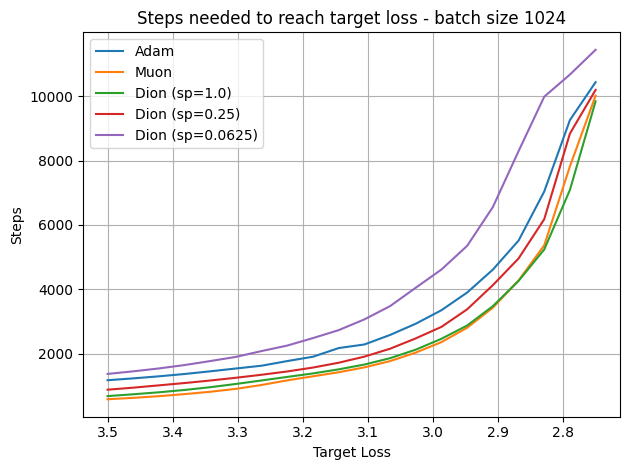

In [350]:
# Plot steps vs target losses
plt.plot(target_losses, adam_steps, label="Adam")
plt.plot(target_losses, muon_steps, label="Muon")
plt.plot(target_losses, dion_1_steps, label="Dion (sp=1.0)")
plt.plot(target_losses, dion_4_steps, label="Dion (sp=0.25)")
plt.plot(target_losses, dion_16_steps, label="Dion (sp=0.0625)")
plt.gca().invert_xaxis()
plt.xlabel("Target Loss")
plt.ylabel("Steps")
plt.title(f"Steps needed to reach target loss - batch size {batch_size}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

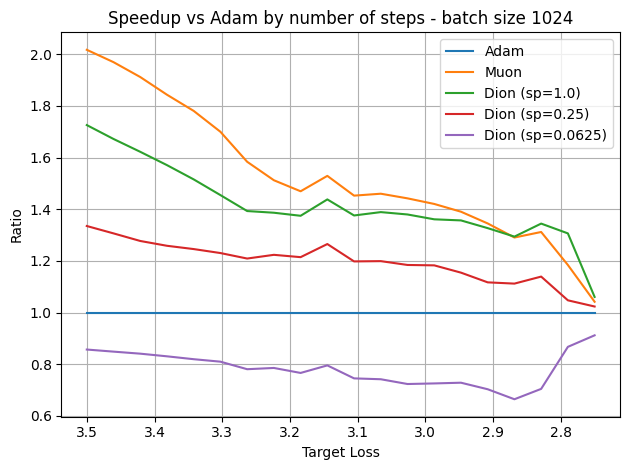

In [351]:
# Plot ratio of steps vs target losses
plt.plot(target_losses, adam_steps / adam_steps, label="Adam")
plt.plot(target_losses, adam_steps / muon_steps, label="Muon")
plt.plot(target_losses, adam_steps / dion_1_steps, label="Dion (sp=1.0)")
plt.plot(target_losses, adam_steps / dion_4_steps, label="Dion (sp=0.25)")
plt.plot(target_losses, adam_steps / dion_16_steps, label="Dion (sp=0.0625)")
plt.gca().invert_xaxis()
plt.xlabel("Target Loss")
plt.ylabel("Ratio")
plt.title(f"Speedup vs Adam by number of steps - batch size {batch_size}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot loss vs time

In [352]:
data = pd.read_csv(val_loss_time_file)
# remove columns with name ending in __MIN or __MAX
selected_cols = [
    col
    for col in data.columns
    if not col.endswith("__MIN")
    and not col.endswith("__MAX")
    and not col.endswith("_step")
]
data = data.loc[:, selected_cols]

print(f"Data columns: {data.columns}")

Data columns: Index(['Relative Time (Process)',
       '(dion)_bs=1024_lr=0.01_sp=1.0_1.3B - val/loss',
       '(dion)_bs=1024_lr=0.01_sp=0.25_1.3B - val/loss',
       '(dion)_bs=1024_lr=0.01_sp=0.0625_1.3B - val/loss',
       '(muon_moonlight)_bs=1024_lr=0.01_sp=1.0_1.3B - val/loss',
       '(adam)_bs=1024_lr=0.002_sp=1.0_1.3B - val/loss'],
      dtype='object')


In [353]:
def create_time_interp(data, name, sparsity=None):
    col_name = get_column_by_name(data, name, sparsity)
    time_col_name = get_column_by_name(data, "time")

    # Remove NaN values
    col_time_data = data[[col_name, time_col_name]].dropna()
    col_data = col_time_data[col_name]
    time_data = col_time_data[time_col_name]

    idx = np.argsort(col_data)
    interp = PchipInterpolator(col_data.iloc[idx], time_data.iloc[idx])
    return interp


adam_time_interp = create_time_interp(data, "adam")
muon_time_interp = create_time_interp(data, "muon")
dion_1_time_interp = create_time_interp(data, "dion", sparsity=1.0)
dion_4_time_interp = create_time_interp(data, "dion", sparsity=0.25)
dion_16_time_interp = create_time_interp(data, "dion", sparsity=0.0625)

In [354]:
adam_time = adam_time_interp(target_losses)
muon_time = muon_time_interp(target_losses)
dion_1_time = dion_1_time_interp(target_losses)
dion_4_time = dion_4_time_interp(target_losses)
dion_16_time = dion_16_time_interp(target_losses)

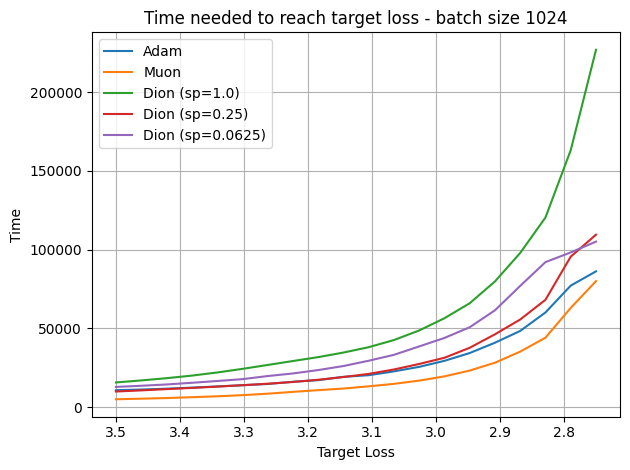

In [355]:
# Plot time vs target losses
plt.plot(target_losses, adam_time, label="Adam")
plt.plot(target_losses, muon_time, label="Muon")
plt.plot(target_losses, dion_1_time, label="Dion (sp=1.0)")
plt.plot(target_losses, dion_4_time, label="Dion (sp=0.25)")
plt.plot(target_losses, dion_16_time, label="Dion (sp=0.0625)")
plt.gca().invert_xaxis()
plt.xlabel("Target Loss")
plt.ylabel("Time")
plt.title(f"Time needed to reach target loss - batch size {batch_size}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

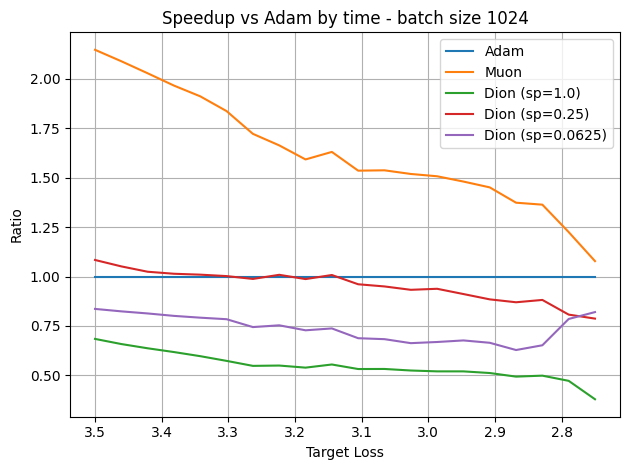

In [356]:
# Plot ratio of time vs target losses
plt.plot(target_losses, adam_time / adam_time, label="Adam")
plt.plot(target_losses, adam_time / muon_time, label="Muon")
plt.plot(target_losses, adam_time / dion_1_time, label="Dion (sp=1.0)")
plt.plot(target_losses, adam_time / dion_4_time, label="Dion (sp=0.25)")
plt.plot(target_losses, adam_time / dion_16_time, label="Dion (sp=0.0625)")
plt.gca().invert_xaxis()
plt.xlabel("Target Loss")
plt.ylabel("Ratio")
plt.title(f"Speedup vs Adam by time - batch size {batch_size}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot time speedup vs batch size

In [357]:
batch_sizes = [256, 1024, 4096, 16384]

# Load data
files = [f"val_loss_time_bs_{bs}.csv" for bs in batch_sizes]
data = []
for file in files:
    df = pd.read_csv(file)
    # remove columns with name ending in __MIN or __MAX
    selected_cols = [
        col
        for col in df.columns
        if not col.endswith("__MIN")
        and not col.endswith("__MAX")
        and not col.endswith("_step")
    ]
    df = df.loc[:, selected_cols]
    data.append(df)


# Create interpolators for each batch size
adam_interps = []
muon_interps = []
dion_1_interps = []
dion_4_interps = []
for df in data:
    adam_interps.append(create_time_interp(df, "adam"))
    muon_interps.append(create_time_interp(df, "muon"))
    dion_1_interps.append(create_time_interp(df, "dion", sparsity=1.0))
    dion_4_interps.append(create_time_interp(df, "dion", sparsity=0.25))

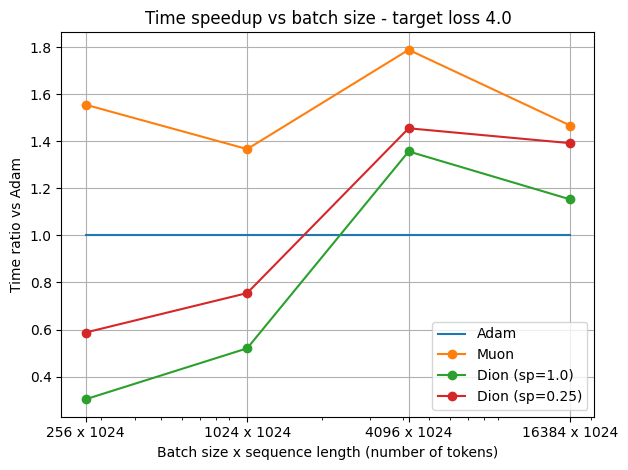

In [358]:
target_loss = 4.0
sequence_length = 1024
num_tokens = np.array(batch_sizes) * sequence_length

# Calculate ratios of time to target loss for each batch size
muon_ratios = []
dion_1_ratios = []
dion_4_ratios = []

for i, bs in enumerate(batch_sizes):
    adam_time = adam_interps[i](target_loss)
    muon_time = muon_interps[i](target_loss)
    dion_1_time = dion_1_interps[i](target_loss)
    dion_4_time = dion_4_interps[i](target_loss)

    muon_ratios.append(adam_time / muon_time)
    dion_1_ratios.append(adam_time / dion_1_time)
    dion_4_ratios.append(adam_time / dion_4_time)

# Plot ratios vs number of tokens
plt.plot(num_tokens, [1] * len(num_tokens), label="Adam")
plt.plot(num_tokens, muon_ratios, marker="o", label="Muon")
plt.plot(num_tokens, dion_1_ratios, marker="o", label="Dion (sp=1.0)")
plt.plot(num_tokens, dion_4_ratios, marker="o", label="Dion (sp=0.25)")

plt.xscale("log")
plt.xlabel("Batch size x sequence length (number of tokens)")
plt.ylabel("Time ratio vs Adam")
plt.xticks(num_tokens, labels=[f"{bs} x 1024" for bs in batch_sizes])
plt.title(f"Time speedup vs batch size - target loss {target_loss}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot steps speedup vs batch size

In [359]:
batch_sizes = [256, 1024, 4096, 16384]

# Load data
files = [f"val_loss_steps_bs_{bs}.csv" for bs in batch_sizes]
data = []
for file in files:
    df = pd.read_csv(file)
    # remove columns with name ending in __MIN or __MAX
    selected_cols = [
        col
        for col in df.columns
        if not col.endswith("__MIN")
        and not col.endswith("__MAX")
        and not col.endswith("_step")
    ]
    df = df.loc[:, selected_cols]
    data.append(df)


# Create interpolators for each batch size
adam_interps = []
muon_interps = []
dion_1_interps = []
dion_4_interps = []
for df in data:
    adam_interps.append(create_interp(df, "adam"))
    muon_interps.append(create_interp(df, "muon"))
    dion_1_interps.append(create_interp(df, "dion", sparsity=1.0))
    dion_4_interps.append(create_interp(df, "dion", sparsity=0.25))

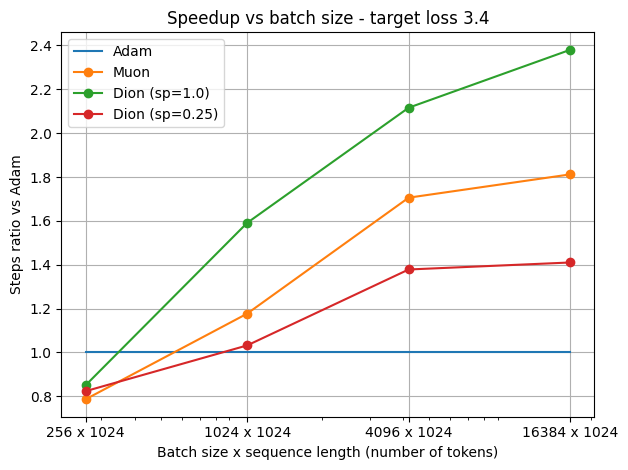

In [369]:
target_loss = 3.4
sequence_length = 1024
num_tokens = np.array(batch_sizes) * sequence_length

# Calculate ratios of time to target loss for each batch size
muon_ratios = []
dion_1_ratios = []
dion_4_ratios = []

for i, bs in enumerate(batch_sizes):
    adam_time = adam_interps[i](target_loss)
    muon_time = muon_interps[i](target_loss)
    dion_1_time = dion_1_interps[i](target_loss)
    dion_4_time = dion_4_interps[i](target_loss)

    muon_ratios.append(adam_time / muon_time)
    dion_1_ratios.append(adam_time / dion_1_time)
    dion_4_ratios.append(adam_time / dion_4_time)

# Plot ratios vs number of tokens
plt.plot(num_tokens, [1] * len(num_tokens), label="Adam")
plt.plot(num_tokens, muon_ratios, marker="o", label="Muon")
plt.plot(num_tokens, dion_1_ratios, marker="o", label="Dion (sp=1.0)")
plt.plot(num_tokens, dion_4_ratios, marker="o", label="Dion (sp=0.25)")

plt.xscale("log")
plt.xlabel("Batch size x sequence length (number of tokens)")
plt.ylabel("Steps ratio vs Adam")
plt.xticks(num_tokens, labels=[f"{bs} x 1024" for bs in batch_sizes])
plt.title(f"Speedup vs batch size - target loss {target_loss}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()